![banner image](resources/banner.png)

# **Análisis Exploratorio:** Dinámicas Sociales y Moralidad Colectiva en Reddit: Un Estudio del Subreddit r/AmlTheA**hole utilizando técnicas de Machine Learning

- Carlos Andres Espitia Alfonso 
- Michael Santiago Moreno Bravo 
- Juan David Salguero Medina 
- Juan Diego Yepes Parra

## 1. Introducción y entendimiento de los datos

Las redes sociales han transformado profundamente la forma en que las personas interactúan, opinan y toman decisiones colectivas. Reddit, una de las plataformas más dinámicas y estructuradas, destaca por sus "subreddits": comunidades especializadas donde los usuarios pueden publicar contenido, votar y debatir sobre temas específicos de manera anónima. Dentro de este ecosistema, el subreddit r/AmITheA\*\*hole (AITA) ha ganado una gran popularidad como espacio donde las personas exponen dilemas personales y solicitan juicios colectivos sobre su comportamiento en situaciones complejas.

Este subreddit representa una fuente de datos única para analizar dinámicas sociales en línea, ya que las publicaciones no solo contienen texto narrativo, sino también interacciones comunitarias como votos y comentarios que culminan en un veredicto colectivo (ej. NTA – "Not the A\*\*hole", YTA – "You’re the A\*\*hole", entre otros). A pesar de que los votos positivos (upvotes) y negativos (downvotes) no determinan directamente el veredicto, ofrecen una perspectiva adicional sobre la recepción e interés que generan las publicaciones dentro de la comunidad.

### 1.1. Objetivo del Análisis Exploratorio de Datos (EDA)

Este análisis exploratorio busca investigar y visualizar las dinámicas internas del subreddit r/AITA desde múltiples perspectivas. Los objetivos principales incluyen:

* Contrastar la distribución de votos (upvotes/downvotes) con los veredictos asignados.
* Explorar la popularidad y características textuales de las publicaciones más votadas.
* Identificar patrones en la longitud de los textos, temas frecuentes y otros factores que podrían influir en la aceptación o rechazo por parte de la comunidad.

A continuación se muestran las operaciones para entender el dataset:

In [1]:
import sqlite3
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [2]:
conn = sqlite3.connect("data/AmITheAsshole.sqlite")
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())


[('submission',), ('comment',)]


In [3]:
cursor.execute("PRAGMA table_info(submission);")
print("Submission table:")
print(cursor.fetchall())

cursor.execute("PRAGMA table_info(comment);")
print("Comment table:")
print(cursor.fetchall())

Submission table:
[(0, 'id', 'INTEGER', 1, None, 1), (1, 'submission_id', 'VARCHAR(255)', 1, None, 0), (2, 'title', 'TEXT', 1, None, 0), (3, 'selftext', 'TEXT', 1, None, 0), (4, 'created_utc', 'DATE', 1, None, 0), (5, 'permalink', 'TEXT', 1, None, 0), (6, 'score', 'INTEGER', 1, None, 0)]
Comment table:
[(0, 'id', 'INTEGER', 1, None, 1), (1, 'submission_id', 'INTEGER', 1, None, 0), (2, 'message', 'TEXT', 1, None, 0), (3, 'comment_id', 'VARCHAR(255)', 1, None, 0), (4, 'parent_id', 'VARCHAR(255)', 1, None, 0), (5, 'created_utc', 'DATE', 1, None, 0), (6, 'score', 'INTEGER', 1, None, 0)]


In [4]:
df_sub = pd.read_sql_query("SELECT * FROM submission LIMIT 5;", conn)
df_sub

,id,submission_id,title,selftext,created_utc,permalink,score
0,1,xt1ksm,AITA Monthly Open Forum Spooktober 2022,#Keep things civil. Rules still apply.\n\n##Th...,1664646465,/r/AmItheAsshole/comments/xt1ksm/aita_monthly_...,592
1,2,yiplwk,AITA for asking my friend to move a picture of...,"\n\nMe (M32) and my wife, Dahlia (F28) lost ou...",1667251988,/r/AmItheAsshole/comments/yiplwk/aita_for_aski...,16582
2,3,yiv572,AITA for asking my husband to stay with me whi...,Throwaway my family knows my account. I'll get...,1667266450,/r/AmItheAsshole/comments/yiv572/aita_for_aski...,4079
3,4,yimgaf,AITA for telling my SIL to stop talking about ...,My (37M) wife (37F) is pregnant with our first...,1667245059,/r/AmItheAsshole/comments/yimgaf/aita_for_tell...,9728
4,5,yin7pf,"AITA for wanting to meet my ""daughter"" after g...",Long story short: in my (40f) twenties I had a...,1667246573,/r/AmItheAsshole/comments/yin7pf/aita_for_want...,6889


In [5]:
df_comm = pd.read_sql_query("SELECT * FROM comment LIMIT 5;", conn)
df_comm

,id,submission_id,message,comment_id,parent_id,created_utc,score
0,1,xt1ksm,Do people with two digits to their age really ...,irs5v1y,t3_xt1ksm,1665421334,59
1,2,xt1ksm,Lots of posts in the last 3-4 days about rando...,isdxgsq,t3_xt1ksm,1665813660,55
2,3,xt1ksm,Sometimes I think people are making up stories...,iryatl4,t3_xt1ksm,1665529128,40
3,4,xt1ksm,Saw it on FB but it's hilarious how threads wi...,is3i5i9,t3_xt1ksm,1665622760,33
4,5,xt1ksm,The OP: My MIL can be a bit petty sometimes\n\...,ituw9ym,t3_xt1ksm,1666793880,32


In [6]:
df_submissions = pd.read_sql_query("SELECT submission_id, title, selftext, created_utc, score FROM submission;", conn)
df_comments = pd.read_sql_query("SELECT submission_id, message FROM comment;", conn)
df_number_of_comments = pd.read_sql_query(
    "SELECT submission_id, COUNT(*) as num_comments FROM comment GROUP BY submission_id;",
    conn
)

In [7]:
print(len(df_comments))
print(len(df_submissions))
print(len(df_number_of_comments))

9101374
30994
30986


In [8]:
verdict_keywords = ['NTA', 'YTA', 'ESH', 'NAH', 'INFO']

def extract_verdict(text):
    for keyword in verdict_keywords:
        if keyword in text:
            return keyword
    return None

df_comments['label'] = df_comments['message'].apply(extract_verdict)
df_comments = df_comments[df_comments['label'].notnull()]

In [9]:
submission_verdicts = df_comments.groupby('submission_id')['label'].apply(lambda x: Counter(x).most_common(1)[0][0]).reset_index()
label_counts = df_comments.groupby(['submission_id', 'label']).size().unstack(fill_value=0).reset_index()
df_submissions = df_submissions.merge(label_counts, on='submission_id', how='left')
df_submissions = df_submissions.merge(df_number_of_comments, on='submission_id', how='left')

df_merged = df_submissions.merge(submission_verdicts, on='submission_id')
df_merged['text'] = df_merged['title'] + ' ' + df_merged['selftext']

In [10]:
df_merged

,submission_id,title,selftext,created_utc,score,ESH,INFO,NAH,NTA,YTA,num_comments,label,text
0,xt1ksm,AITA Monthly Open Forum Spooktober 2022,#Keep things civil. Rules still apply.\n\n##Th...,1664646465,592,4.0,1.0,4.0,18.0,10.0,496.0,NTA,AITA Monthly Open Forum Spooktober 2022 #Keep ...
1,yiplwk,AITA for asking my friend to move a picture of...,"\n\nMe (M32) and my wife, Dahlia (F28) lost ou...",1667251988,16582,0.0,6.0,0.0,0.0,344.0,561.0,YTA,AITA for asking my friend to move a picture of...
2,yiv572,AITA for asking my husband to stay with me whi...,Throwaway my family knows my account. I'll get...,1667266450,4079,0.0,0.0,0.0,1.0,382.0,517.0,YTA,AITA for asking my husband to stay with me whi...
3,yimgaf,AITA for telling my SIL to stop talking about ...,My (37M) wife (37F) is pregnant with our first...,1667245059,9728,5.0,2.0,17.0,200.0,8.0,584.0,NTA,AITA for telling my SIL to stop talking about ...
4,yin7pf,"AITA for wanting to meet my ""daughter"" after g...",Long story short: in my (40f) twenties I had a...,1667246573,6889,3.0,2.0,23.0,29.0,174.0,613.0,YTA,"AITA for wanting to meet my ""daughter"" after g..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30825,17vg85i,AITA for saying to my wife that I’m the one wh...,My (43M) niece (14F) is being raised by my wif...,1700006346,25,1.0,0.0,0.0,0.0,50.0,78.0,YTA,AITA for saying to my wife that I’m the one wh...
30826,17v5nna,AITA for snapping at BIL for accusing me of st...,I (48M) was recently at my sister’s (33F) hous...,1699978447,92,1.0,0.0,0.0,10.0,2.0,23.0,NTA,AITA for snapping at BIL for accusing me of st...
30827,17v959p,AITA for planning a spotlight dance with just ...,I (25M) will be getting married to my amazing ...,1699987608,53,0.0,0.0,0.0,18.0,1.0,33.0,NTA,AITA for planning a spotlight dance with just ...
30828,17ventx,AITA for telling my parents that my siblings a...,"I’m catching flak from this from all sides, bu...",1700002170,24,0.0,1.0,0.0,14.0,0.0,24.0,NTA,AITA for telling my parents that my siblings a...


In [11]:
print(df_merged['label'].value_counts())

label
NTA     25113
YTA      5327
ESH       243
NAH       126
INFO       21
Name: count, dtype: int64


In [12]:
import datetime

earliest_date = df_merged['created_utc'].min()
latest_date = df_merged['created_utc'].max()
print("Earliest created_utc:", datetime.datetime.fromtimestamp(earliest_date))
print("Latest created_utc:", datetime.datetime.fromtimestamp(latest_date))

Earliest created_utc: 2022-10-01 12:47:45
Latest created_utc: 2023-11-14 18:59:06


### 1.2. Descripción del Conjunto de Datos

El dataset utilizado para este estudio fue recopilado desde el subreddit r/AmITheA\*\*hole e incluye publicaciones con distintos niveles de interacción y veredictos comunitarios. Las características principales del dataset son:

* **Tamaño del dataset**: 30994 publicaciones individuales.
* **Rango temporal**: Desde 2022-10-01 hasta 2023-11-14.
* **Campos principales**:

  * `submission_id`: Título de la publicación.
  * `text`: Título y cuerpo de la historia contada concatenados.
  * `score`: Puntuación neta (upvotes - downvotes).
  * `label`: Veredicto asignado por la comunidad (YTA, NTA, ESH, NAH, etc.).
  * `created_utc`: Fecha de publicación en formato UTC.
  * `num_comments`: Numero de comentatios de la publicación.

Este conjunto de datos permite analizar, de forma cuantitativa y cualitativa, los factores que intervienen en la recepción de una publicación, los patrones narrativos predominantes y cómo se manifiesta la toma de decisiones colectivas dentro de comunidades virtuales.

## 2. Limpieza y preprocesamiento de los datos

Las siguientes operaciones de limpieza se hacen solamente para entender mejor los datos y prepararlos para las gráficas, no necesariamente aportan algun entendimiento sobre los mismos.

In [13]:
print(df_merged.isnull().sum())

submission_id    0
title            0
selftext         0
created_utc      0
score            0
ESH              0
INFO             0
NAH              0
NTA              0
YTA              0
num_comments     0
label            0
text             0
dtype: int64


In [14]:
df_merged['created_datetime'] = df_merged['created_utc'].apply(datetime.datetime.fromtimestamp)

## 3. Distribuciones de los datos

<!-- Post length distribution (title and body).
Distribution of upvotes, downvotes, and total score.
Posting frequency over time (time series).
Top verdicts (e.g., NTA, YTA, ESH, NAH). -->


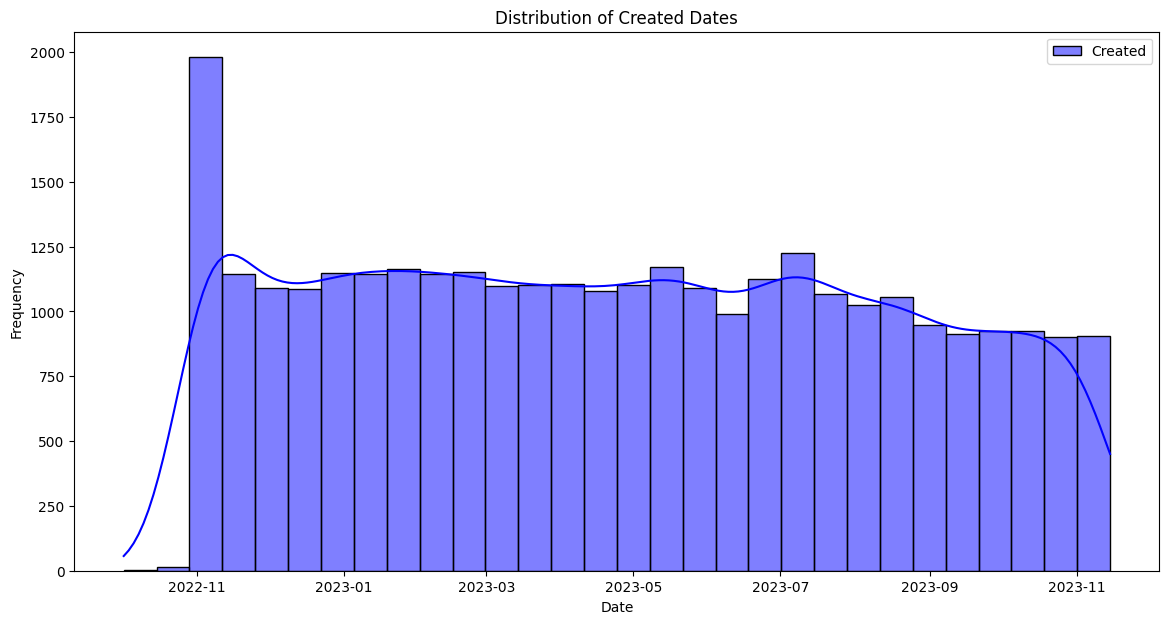

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
sns.histplot(df_merged['created_datetime'], bins=30, kde=True, color='blue', label='Created')
plt.legend()
plt.title('Distribution of Created Dates')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()

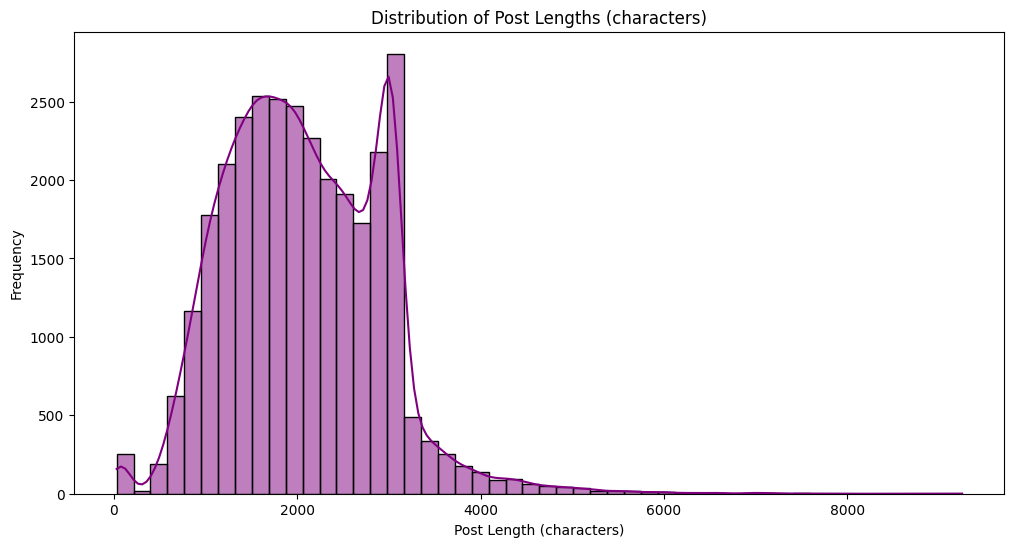

In [16]:
plt.figure(figsize=(12, 6))
post_lengths = df_merged['text'].str.len()
sns.histplot(post_lengths, bins=50, kde=True, color='purple')
plt.title('Distribution of Post Lengths (characters)')
plt.xlabel('Post Length (characters)')
plt.ylabel('Frequency')
plt.show()

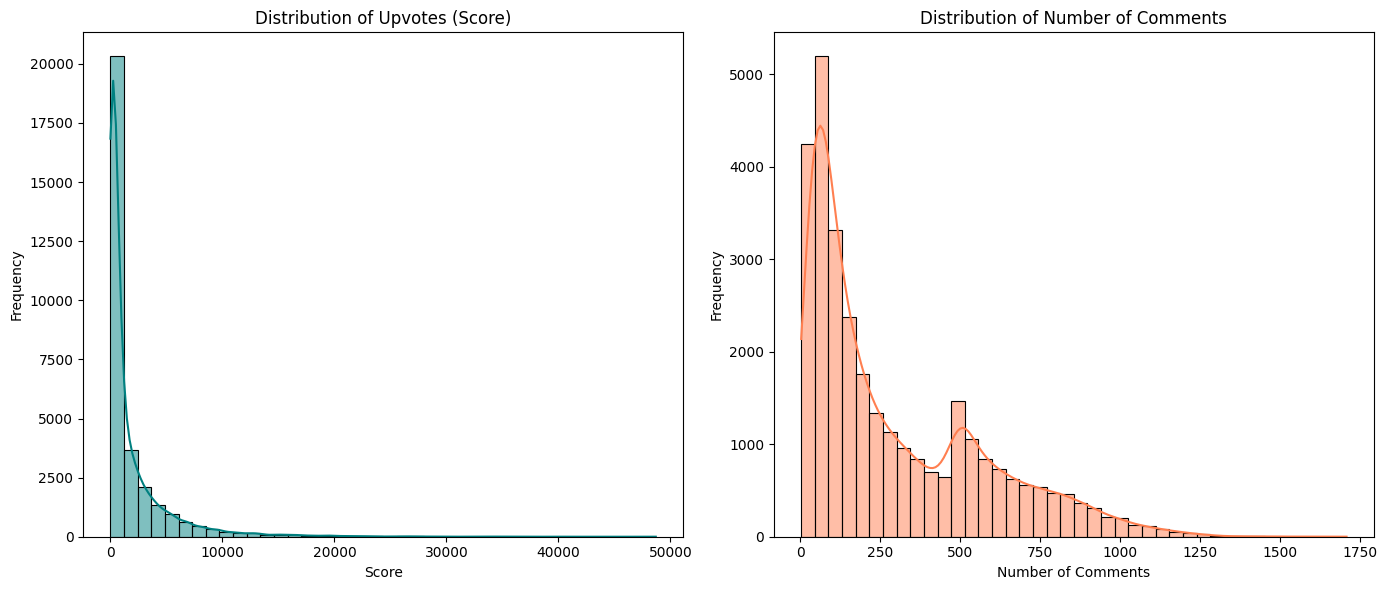

In [17]:
plt.figure(figsize=(14, 6))

# Distribution of scores
plt.subplot(1, 2, 1)
sns.histplot(df_merged['score'], bins=40, kde=True, color='teal')
plt.title('Distribution of Upvotes (Score)')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Distribution of number of comments
plt.subplot(1, 2, 2)
sns.histplot(df_merged['num_comments'], bins=40, kde=True, color='coral')
plt.title('Distribution of Number of Comments')
plt.xlabel('Number of Comments')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

/var/folders/05/h_xl6mtd7h1dhnqt5jbnbycc0000gn/T/ipykernel_9275/480931438.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df_merged, order=df_merged['label'].value_counts().index, palette='viridis', ax=ax[0])


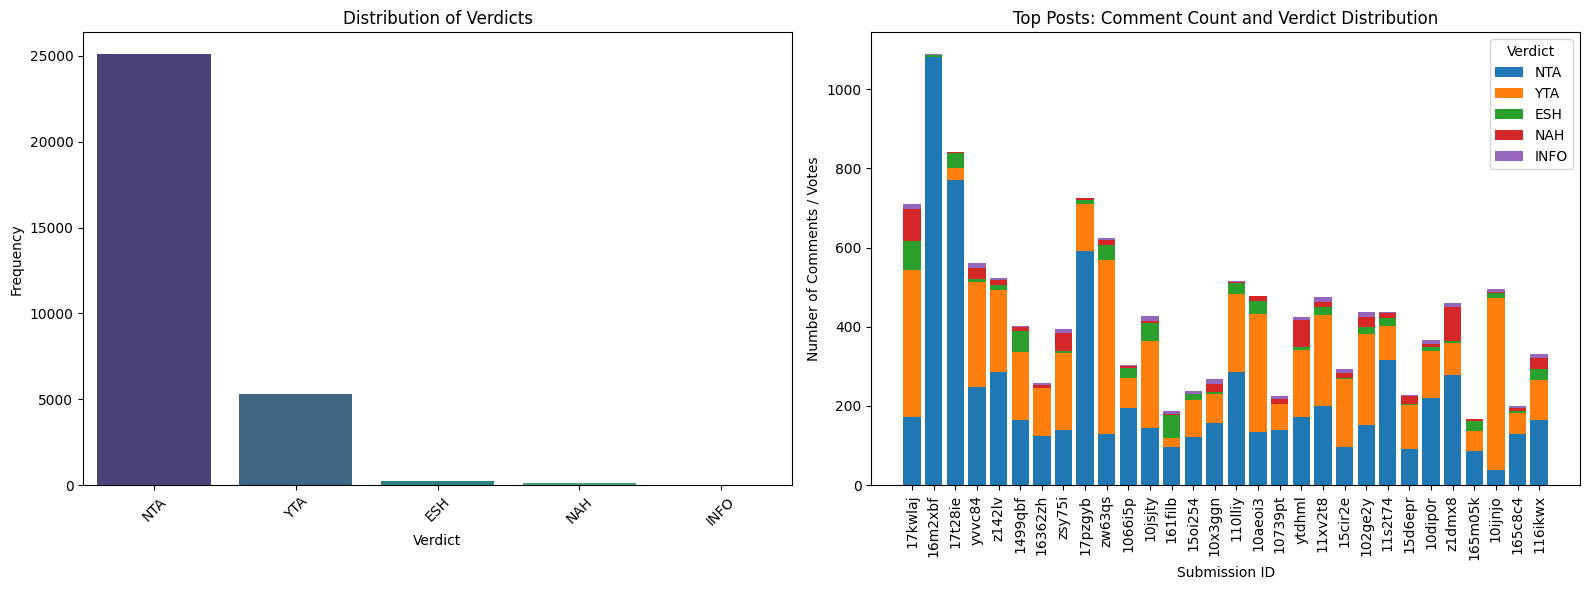

In [18]:
import numpy as np
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Distribution of verdicts
sns.countplot(x='label', data=df_merged, order=df_merged['label'].value_counts().index, palette='viridis', ax=ax[0])
ax[0].set_title('Distribution of Verdicts')
ax[0].set_xlabel('Verdict')
ax[0].set_ylabel('Frequency')
ax[0].tick_params(axis='x', rotation=45)

# Distribution of count of verdicts vs. total comments for top 30 posts
verdict_cols = ['NTA', 'YTA', 'ESH', 'NAH', 'INFO']
top_n = 30 
top_posts = df_merged.nlargest(top_n, 'num_comments').copy()
bar_bottom = np.zeros(top_n)

for v in verdict_cols:
    ax[1].bar(
        top_posts['submission_id'],
        top_posts[v],
        bottom=bar_bottom,
        label=v
    )
    bar_bottom += top_posts[v].values

ax[1].set_title('Top Posts: Comment Count and Verdict Distribution')
ax[1].set_xlabel('Submission ID')
ax[1].set_ylabel('Number of Comments / Votes')
ax[1].tick_params(axis='x', rotation=90)
ax[1].legend(title='Verdict')

plt.tight_layout()
plt.show()


In [19]:
idx = 1
row = df_merged.iloc[idx]

print(f"Title: {row['title']}")
print("_" * 80)
print("\nBody:\n")
print(row['selftext'].replace('\n', '.'))
print("_" * 80)
print("\nVerdict:", row['label'])
print("_" * 80)
print("\nScore:", row['score'])
print("_" * 80)
print(f"\nCounts:\t NTA: {row['NTA']}\t YTA: {row['YTA']}\t ESH: {row['ESH']}\t NAH: {row['NAH']}")
print("_" * 80)

submission_id = row['submission_id']
comments = df_comments[df_comments['submission_id'] == submission_id]['message'].tolist()

print(f"\nComments: (total is {row['num_comments']})")
for i, comment in enumerate(comments[:10]):
    print(f"\nComment {i+1}:")
    print(comment.replace('\n', '.'))
    print("\n#######")

Title: AITA for asking my friend to move a picture of him and his wife because it made my wife uncomfortable?
________________________________________________________________________________

Body:

..Me (M32) and my wife, Dahlia (F28) lost our apartment 2 months ago and moved in with mom temporarily. Issues began to arise between Dahlia and mom and I had to ask my friend, Anthony (M31) to let us move in til I get enough money to rent out. His wife was away visiting family and he agreed but even there, some issues started to arise....Fyi, Dahlia is very shy around Anthony. She grew up in conservative home and so it's understandable, but sometimes it can be a bit much I admit that! ..For example, she freaked out when she accidently drank from his glass, she also once made a fuss when he passed by the guests room when she was lying down and the door was open. Thankfully, Anthony was super understanding and we were able to talk some of these issues out....Last night, Dahlia was passing th

### 3.1. Contraste de votos y métricas

/var/folders/05/h_xl6mtd7h1dhnqt5jbnbycc0000gn/T/ipykernel_9275/3437447713.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='label', y='score', data=df_merged, order=verdict_cols, palette='Set2', alpha=0.4, jitter=True)


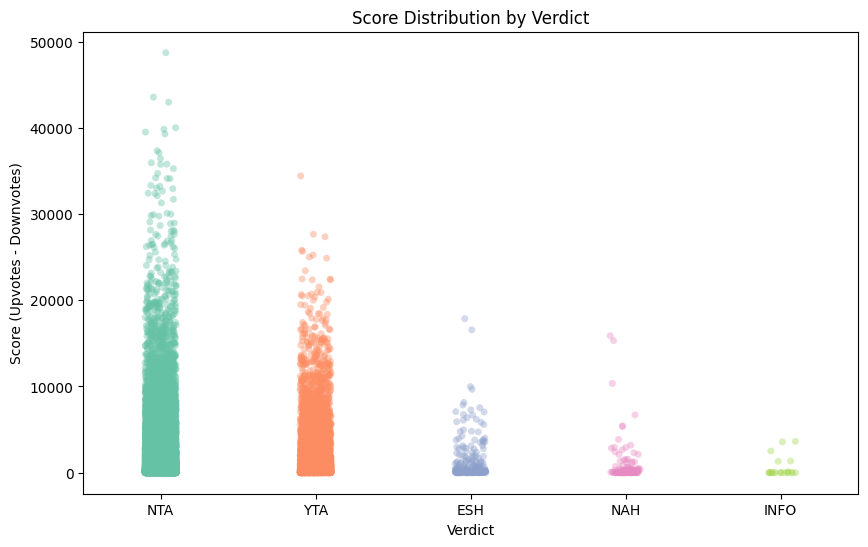

In [20]:
plt.figure(figsize=(10, 6))
sns.stripplot(x='label', y='score', data=df_merged, order=verdict_cols, palette='Set2', alpha=0.4, jitter=True)
plt.title('Score Distribution by Verdict')
plt.xlabel('Verdict')
plt.ylabel('Score (Upvotes - Downvotes)')
plt.show()

/var/folders/05/h_xl6mtd7h1dhnqt5jbnbycc0000gn/T/ipykernel_9275/2114453482.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_YTA', y='score', data=df_merged, palette='Set1')


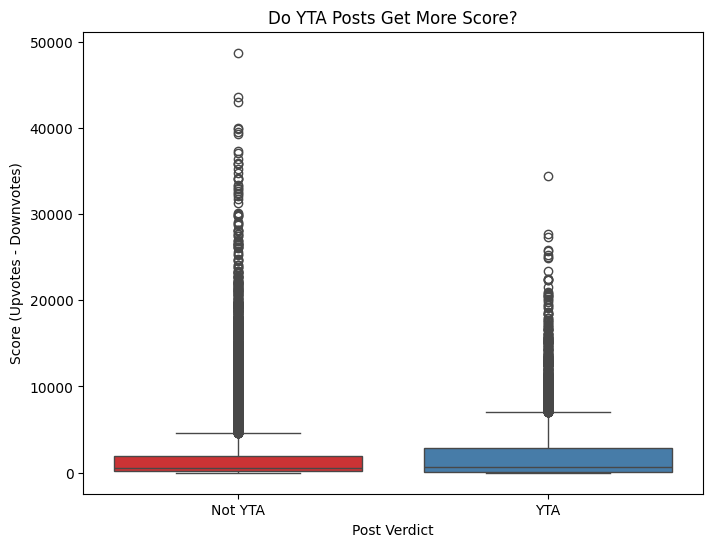

In [21]:
plt.figure(figsize=(8, 6))
# Create a boolean column for YTA verdict
df_merged['is_YTA'] = df_merged['label'] == 'YTA'
sns.boxplot(x='is_YTA', y='score', data=df_merged, palette='Set1')
plt.xticks([0, 1], ['Not YTA', 'YTA'])
plt.title('Do YTA Posts Get More Score?')
plt.xlabel('Post Verdict')
plt.ylabel('Score (Upvotes - Downvotes)')
plt.show()

### 3.2. Análisis no supervisado con clustering

Con el objetivo de identificar agrupaciones naturales dentro del corpus de publicaciones de Reddit, se aplicó KMeans clustering sobre una representación vectorial TF-IDF del texto. Este análisis no supervisado permite descubrir patrones latentes en la forma en que se narran las historias, independientemente del veredicto explícito.


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# Balancear clases si es necesario (esto debes ajustarlo según tu análisis)
df_balanced = df_merged[df_merged['label'].isin(['NTA', 'YTA', 'ESH', 'NAH'])]  # opcional
X = df_balanced['text']
y = df_balanced['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer(stop_words='english', max_features=20000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


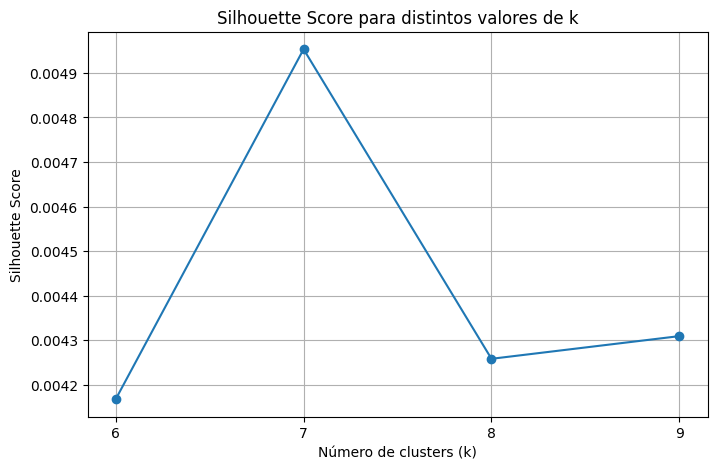

In [23]:
silhouette_scores = []
k_values = range(6, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_train_vec)
    score = silhouette_score(X_train_vec, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score para distintos valores de k')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()


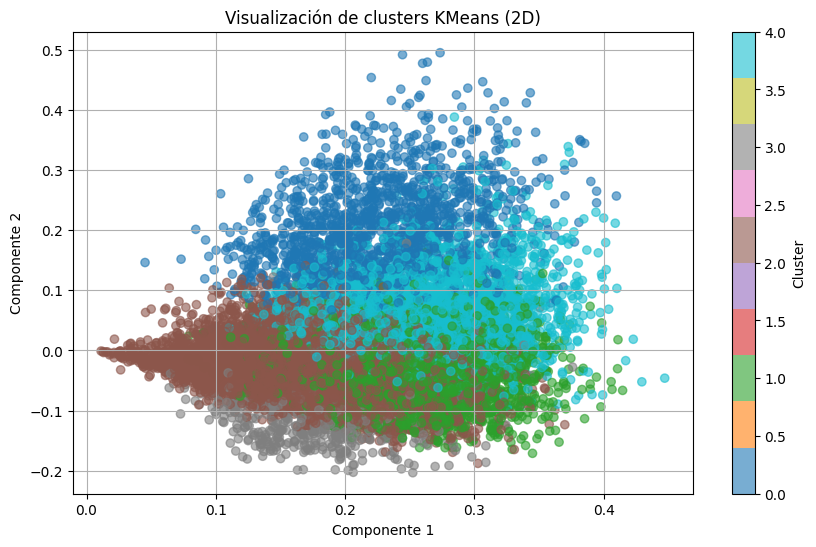

In [24]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_train_vec)
train_clusters = kmeans.predict(X_train_vec)
svd = TruncatedSVD(n_components=2, random_state=42)
X_reduced = svd.fit_transform(X_train_vec)

plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=train_clusters, cmap='tab10', alpha=0.6)
plt.title('Visualización de clusters KMeans (2D)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [25]:
terms = vectorizer.get_feature_names_out()
n_top_words = 10

for i, center in enumerate(kmeans.cluster_centers_):
    print(f"\n🌀 Cluster {i}:")
    top_indices = center.argsort()[::-1][:n_top_words]
    top_terms = [terms[ind] for ind in top_indices]
    print(" - ".join(top_terms))



🌀 Cluster 0:
wedding - dress - sister - family - married - fiancé - said - told - brother - just

🌀 Cluster 1:
husband - wife - kids - daughter - son - told - baby - said - family - just

🌀 Cluster 2:
said - just - told - like - aita - friend - don - didn - time - got

🌀 Cluster 3:
dog - dogs - said - just - house - wife - don - told - home - like

🌀 Cluster 4:
mom - dad - sister - brother - parents - told - family - said - just - like


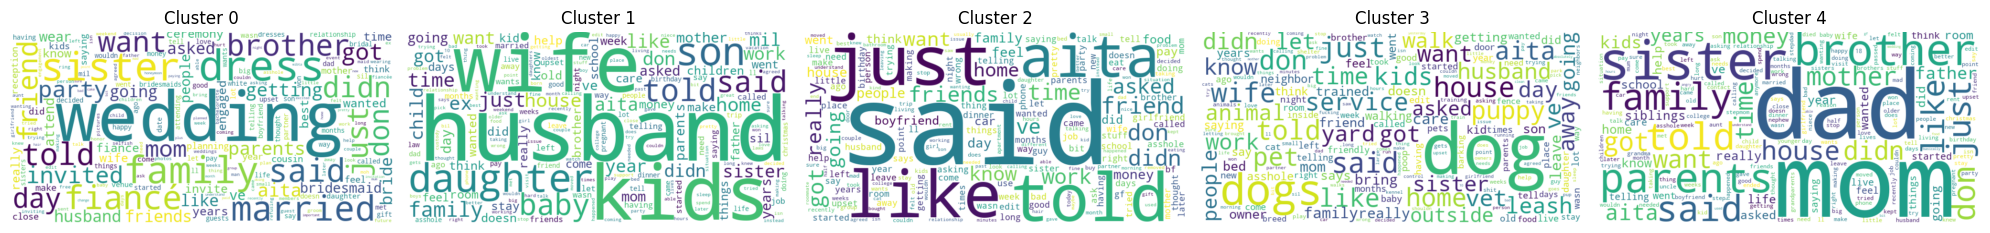

In [ ]:
cluster_word_weights = {}

for i in range(k):
    cluster_indices = np.where(train_clusters == i)[0]
    cluster_tfidf = X_train_vec[cluster_indices]
    summed = cluster_tfidf.sum(axis=0)
    word_weights = np.asarray(summed).flatten()

    filtered_weights = {
        term: weight for term, weight in zip(terms, word_weights)
        if not np.isnan(weight) and weight > 0
    }

    cluster_word_weights[i] = filtered_weights

fig, axes = plt.subplots(1, k, figsize=(20, 5))

for i in range(k):
    freqs = cluster_word_weights[i]

    if len(freqs) == 0:
        print(f"Cluster {i} no tiene palabras suficientes para generar la nube.")
        axes[i].axis('off')
        axes[i].set_title(f'Cluster {i} (vacío)')
        continue

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freqs)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Cluster {i}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### 3.3. Tendencias, análisis de sentimiento

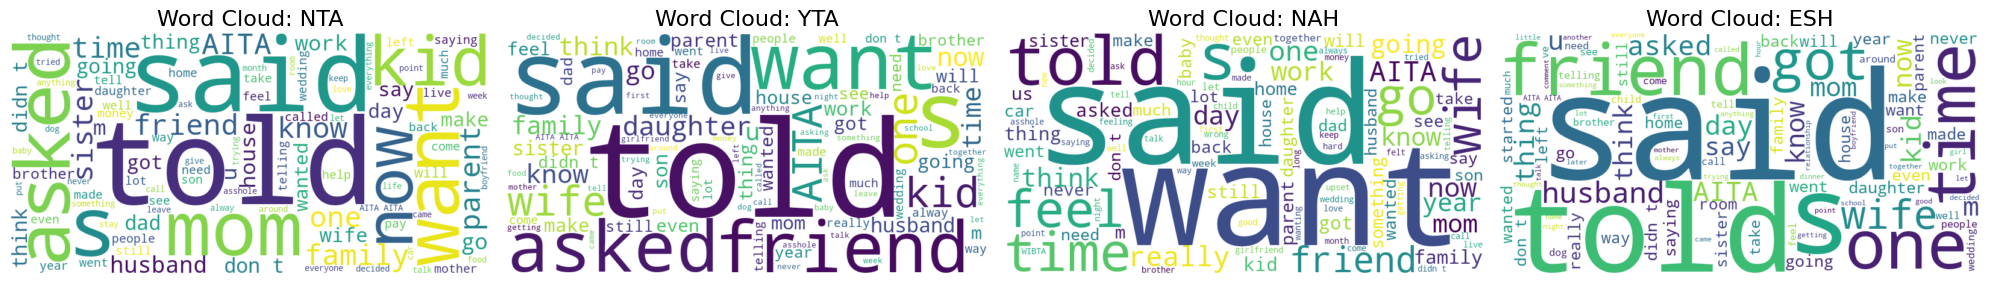

In [27]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt

# Generate word clouds for each verdict label
labels = df_balanced['label'].unique()
n_labels = len(labels)
fig, axes = plt.subplots(1, n_labels, figsize=(5 * n_labels, 5))

for i, label in enumerate(labels):
    text = " ".join(df_balanced[df_balanced['label'] == label]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    ax = axes[i] if n_labels > 1 else axes
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word Cloud: {label}', fontsize=16)
    ax.axis('off')

plt.tight_layout()
plt.show()

/var/folders/05/h_xl6mtd7h1dhnqt5jbnbycc0000gn/T/ipykernel_9275/2318669904.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_phrases, palette='mako')


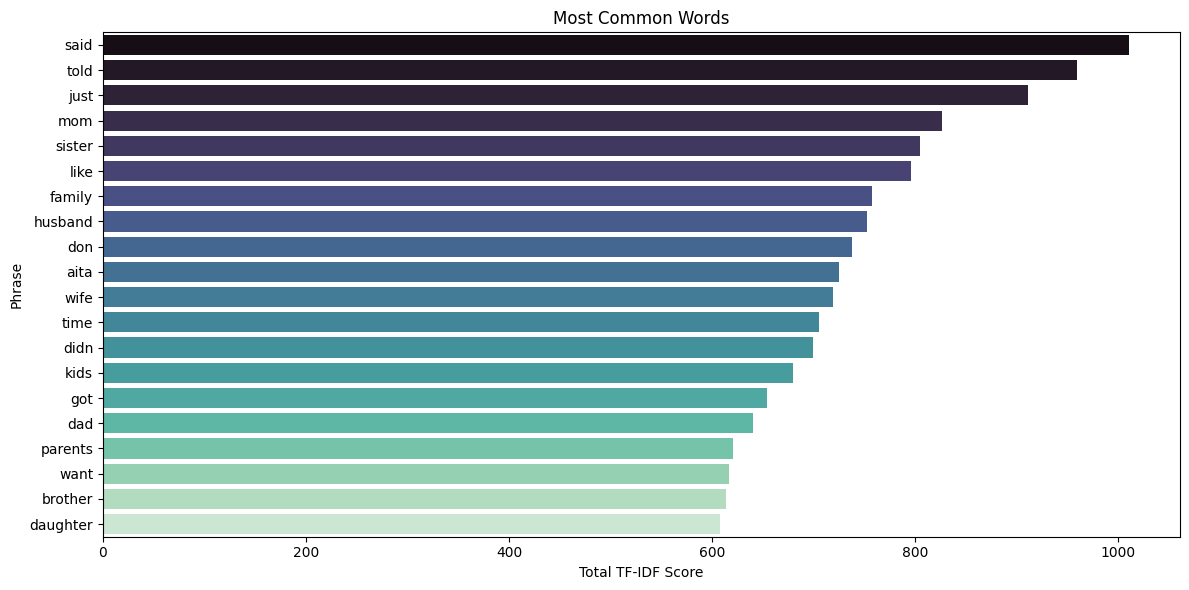

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

tfidf = vectorizer if 'vectorizer' in globals() else TfidfVectorizer(stop_words='english', max_features=20000)
X_tfidf = tfidf.fit_transform(df_balanced['text'])


feature_names = tfidf.get_feature_names_out()
tfidf_sums = X_tfidf.sum(axis=0).A1
top_n_phrases = 20
top_indices = tfidf_sums.argsort()[::-1][:top_n_phrases]
top_phrases = [feature_names[i] for i in top_indices]
top_scores = tfidf_sums[top_indices]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_scores, y=top_phrases, palette='mako')
plt.title('Most Common Words')
plt.xlabel('Total TF-IDF Score')
plt.ylabel('Phrase')
plt.tight_layout()
plt.show()

In [29]:
from transformers import pipeline

top_n = 2000 
top_posts = df_merged.nlargest(top_n, 'num_comments').copy()

sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
sentiment_results = sentiment_analyzer(top_posts['selftext'].tolist(), truncation=True, max_length=512, batch_size=32)

import pandas as pd
sentiment_df = pd.DataFrame(sentiment_results)
sentiment_df.index = top_posts.index

top_posts = top_posts.copy()
top_posts['sentiment_label'] = sentiment_df['label']
top_posts['sentiment_score'] = sentiment_df['score']


Device set to use mps:0


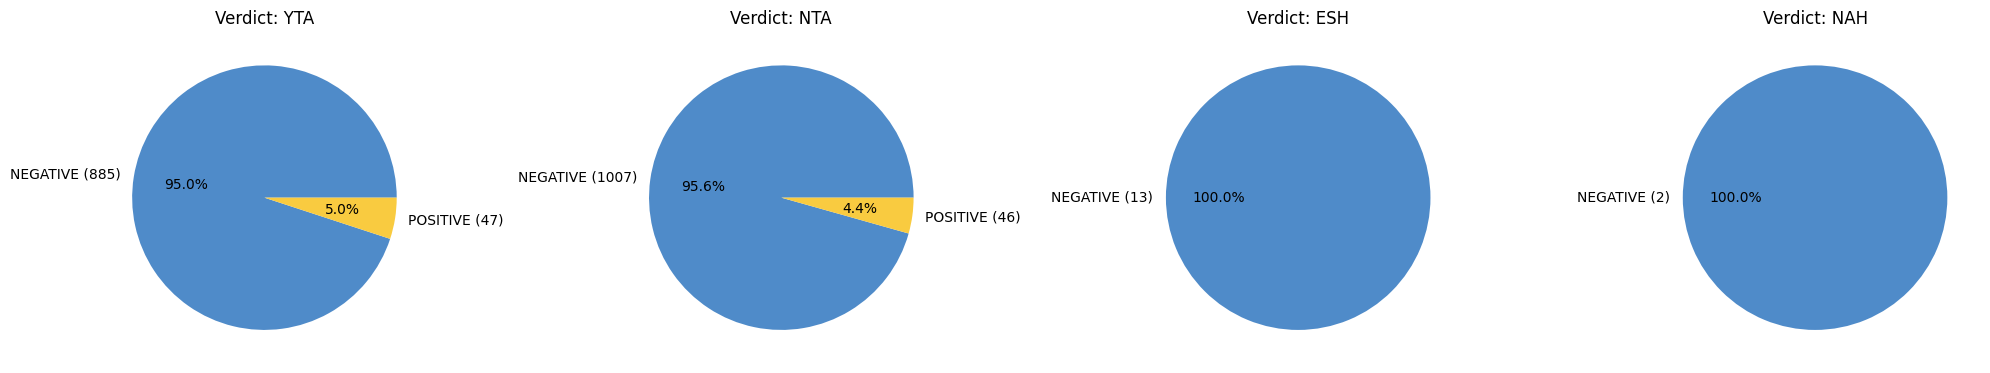

In [30]:
verdicts = top_posts['label'].unique()
n_verdicts = len(verdicts)
fig, axes = plt.subplots(1, n_verdicts, figsize=(5 * n_verdicts, 5))

for i, verdict in enumerate(verdicts):
    data = top_posts[top_posts['label'] == verdict]['sentiment_label'].value_counts()
    ax = axes[i] if n_verdicts > 1 else axes
    ax.pie(
        data,
        labels=[f"{lbl} ({cnt})" for lbl, cnt in zip(data.index, data.values)],
        autopct='%1.1f%%',
        colors=['#4F8BC9', '#F9CB40']
    )
    ax.set_title(f'Verdict: {verdict}')

plt.tight_layout()
plt.show()


## 4. Conclusiones

<!-- Key findings.
Surprising patterns.
Suggestions for modeling or deeper NLP work. -->
